In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import numpy as np
import cmocean.cm as ocm
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import string
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import gsw

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
fig_dir  = os.path.join(proj_dir,'reports','devel','figures')
int_dir = os.path.join(data_dir,'interim')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from visualization.shiftedColorMap import shiftedColorMap
from roms_tools.cartesian_grid_2d import cartesian_grid_2d

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)
from rotate_vector_roms import rotate_vector_roms
from log_progress import log_progress
from calc_z import calc_z

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Transects

In [2]:
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_t15_04.nc')
woa_t = xr.open_dataset(woa_path,decode_times=False).mean('time')
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_s15_04.nc')
woa_s = xr.open_dataset(woa_path,decode_times=False).mean('time')

t = woa_t.t_an
SP = woa_s.s_an

lon_2d,depth_2d = np.meshgrid(t.lon,t.depth)
lat_2d,depth_2d = np.meshgrid(t.lat,t.depth)
p = gsw.p_from_z(-depth_2d,lat_2d)
p_3d = np.repeat(p[:,:,np.newaxis],t.lon.size,axis=2)
lon_3d = np.repeat(lon_2d[:,np.newaxis,:],t.lat.size,axis=1)
lat_3d = np.repeat(lat_2d[:,:,np.newaxis],t.lon.size,axis=2)
SA = gsw.SA_from_SP(SP,p_3d,lon_3d,lat_3d)
pt = gsw.pt0_from_t(SA,t,p_3d)

woa_t['pt']=xr.DataArray(pt,dims=('depth','lat','lon'))

woa = xr.Dataset({'temp':woa_t.pt,'salt':woa_s.s_an})
woa['depth']=-woa.depth

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [3]:
temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_DJFavg.nc')
salt_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_salt_DJFavg.nc')
#zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_DJFavg.nc')
temp = xr.open_dataset(temp_path).temp.squeeze()
salt = xr.open_dataset(salt_path).salt.squeeze()
#zeta = xr.open_dataset(zeta_path).zeta.squeeze()
grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

In [8]:
def make_3D_depth(grd):

    h = grd.h.values
    zice = grd.zice.values
    theta_s = 7
    theta_b = 8
    hc = 250
    N = 31
    Vstretching = 4    
    zeta = np.zeros_like(grd.mask_rho)
        
    depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)
        
    depth_3d =    xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']) 
    #ds = ds.assign_coords(depth = xr.DataArray(depths,dims=['ocean_time','s_rho','eta_rho','xi_rho']))
    
    return depth_3d

import xesmf as xe
def regrid(da):
    da = da.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,woa_t,'nearest_s2d',reuse_weights=True)
    return regridder(da)

from scipy import interpolate

def interp_depth_1D(woa_section,waom_section):
    out = woa_section.copy(deep=True)
    for key in ['temp','salt']:
        for i in np.arange(out.lat.size):
            f = interpolate.interp1d(waom_section.depth[:,i],waom_section[key][:,i],bounds_error=False)
            out[key][:,i] = f(woa_section.depth)
            
    return out

In [9]:
z_rho = make_3D_depth(grd)
waom = xr.Dataset({'temp':temp,'salt':salt,'depth':z_rho})
waom = regrid(waom)

Reuse existing file: nearest_s2d_2650x3150_101x1440.nc
using dimensions ('eta_rho', 'xi_rho') from data variable temp as the horizontal dimensions for this dataset.


In [60]:
plt.rcParams['axes.facecolor']='gray'

def comp_lon(lon,lat):
    sel = {'lon':lon,'lat':lat}
    woa_s = woa.sel(sel).mean('lon')#.dropna('depth','all').dropna('lat','all')
    waom_s = interp_depth_1D(woa_s,waom.sel(sel).mean('lon'))#.dropna('depth','all').dropna('lat','all')
    
    return woa_s.dropna('depth','all').dropna('lat','all'),waom_s.dropna('depth','all').dropna('lat','all')

def plot_lon(lon,lat):
    
    woa_s,waom_s = comp_lon(lon,lat)
    woa_s['depth']=woa_s.depth/1000
    waom_s['depth']=waom_s.depth/1000
    diff = waom_s-woa_s
    
    sr = 0.3#max(diff.salt.max(),-diff.salt.min())
    tr = 2#max(diff.temp.max(),-diff.temp.min())
    
    
    fig,axes = plt.subplots(2,2,figsize = (8.27, 8.))
    
    ax1,ax2,ax3,ax4 = axes.flatten()

    woa_s.temp.plot(ax=ax1,cmap=ocm.thermal,
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. [degC]','pad':0.02})

    diff.temp.plot(ax=ax2,vmin=-tr,vmax=tr,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. diff. [degC]','pad':0.02})

    woa_s.salt.plot(ax=ax3,cmap=ocm.haline,
            cbar_kwargs={'orientation': 'horizontal','label':'Salinity','pad':0.02})

    diff.salt.plot(ax=ax4,vmin=-sr,vmax=sr,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Salinity diff.','pad':0.02})

    
    for ax in [ax2,ax4]:
        ax.set_yticklabels('')
        ax.set_ylabel('')
        
    for ax in [ax3,ax4]:
        ax.set_xticklabels('')
        ax.set_xlabel('')
    
    for ax in [ax1,ax2]:
        ax.set_xlabel('Latitude [degN]')
        
    for ax in [ax1,ax3]:
        ax.set_ylabel('Depth [km]')
    n=0
    for ax in axes.flatten():  
        ax.xaxis.tick_top()
        ax.text(0.01, 0.03, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
                size=12)
        n+=1    
    
    ax1.text(0.3,1.2, "WOA", transform=ax1.transAxes,size=12,weight='bold')
    ax2.text(0.3,1.2, "WAOM-WOA", transform=ax2.transAxes,size=12,weight='bold')
    
        
#fig.subplots_adjust(bottom=0.25)
#cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

#cbar = plt.colorbar(img, cax=cbar_ax,ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
#cbar.set_label(label='Depth in m',weight='bold')

    plt.subplots_adjust(wspace=0.15,hspace=0.175)

    out_path = os.path.join(fig_dir,'onshelf_trans_WOA_WAOM_'+str(sel[0])+'.png')
    fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


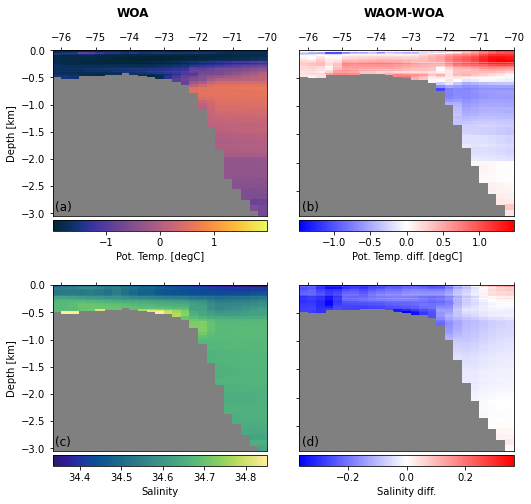

In [53]:
plot_lon(slice(-54,-53),slice(-80,-70))

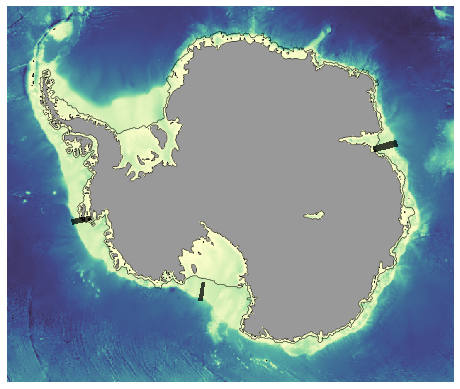

In [70]:
grd_path = os.path.join(data_dir,'interim','grd10_dV.nc')
grd10 = xr.open_dataset(grd_path)

#sels = [[118,120,-67,-65],
#       [-1,1,-70,-67],
#        [72,74,-69.5,-65],
#        [-84,-82,-73,-65]]

sels = [[-171,-169,-78,-75.5],
        #[-151,-149,-80,-65],
        [-103,-101,-73,-70.5],
        #[-1,1,-70,-67],
        #[39,41,-80,-65],
        #[59,61,-80,-65],
        [74,76,-69.5,-66.5]]
        #[139,141,-80,-65],
        #[174,176,-80,-65]]

plt.close()
fig,ax = plt.subplots(figsize=(8,8))
ax.contourf(grd10.mask_rho.values,colors=(('0.6','0.6','0.6')))
(grd10.h+grd10.zice).where(grd10.mask_rho).plot(cmap=ocm.deep,add_colorbar=False)#cbar_kwargs={'label':''})
ax.contour(-grd10.zice.where(grd10.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
ax.contour(grd10.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
ax.set_aspect('equal')
ax.axis('off')

for sel in sels:
    mask = (grd10.lon_rho>sel[0]) & (grd10.lon_rho<sel[1]) & (grd10.lat_rho>sel[2]) & (grd10.lat_rho<sel[3])
    ax.contourf(grd10.mask_rho.where(mask),alpha=0.75,colors='k')

out_path = os.path.join(fig_dir,'onshelf_trans_WOA_WAOM_map.png')
plt.savefig(out_path,format='png',dpi=375)
plt.show()

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


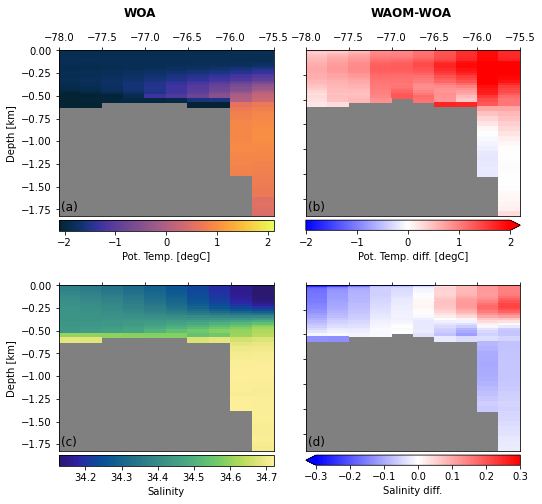

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


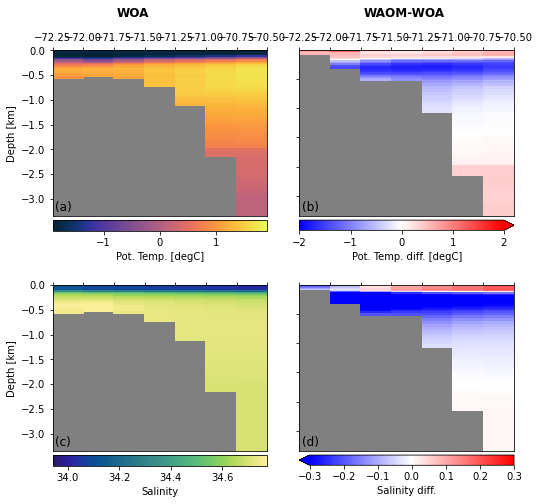

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


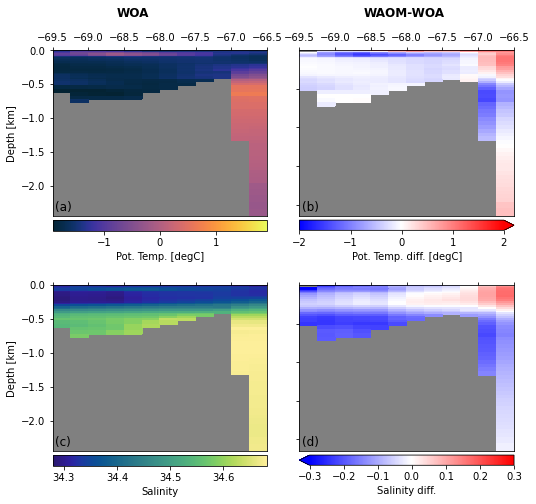

In [71]:
for sel in sels:
    plot_lon(slice(sel[0],sel[1]),slice(sel[2],sel[3]))